# Heart Disease Detection

In this notebook, we first do some EDA to get a better understanding of the data. Then we will create different classification methods to detect patients with a high risk of having heart disease. In the end, we will compare the performance of the models that we made to choose the best one.

The Classification methods that we are going to use are **KNN**, **Decision Tree**, **Logistic Regression** and **SVM**.

You can find the description of the data set in [here](https://www.kaggle.com/ronitf/heart-disease-uci) 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np

# I want my data frame to only show two decimal places for the number, so I change the display format:
pd.options.display.float_format = "{:,.2f}".format

Let's Explore the data and see what it looks like:

# EDA

In [3]:
df = pd.read_csv("02-Heart Disease.csv")
df.head(9)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.40,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.30,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.00,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.50,2,0,3,1


In [4]:
print(df.shape)
df.describe()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


Checking the data types:

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Now let's check if there is any missing value:

In [6]:
df.isna().sum() 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Great, there is no missing value!!

Now I'm  going to create a correlation matrix to see which features have more effect on the target value:

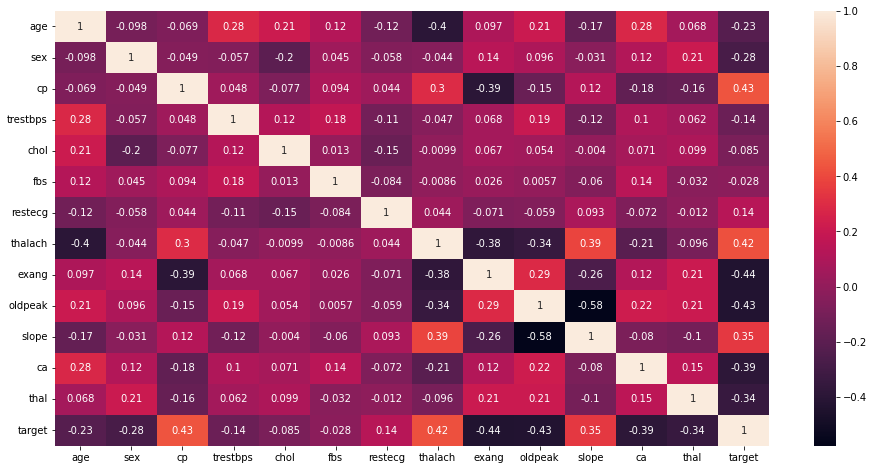

In [7]:
import seaborn as sns

plt.figure(figsize = (16, 8))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

It seems that "cp", "thalach", "slope" and "restepg" have more correlation with target value. but as we see in the matrix, "thalach" and "slope" have a considerable correlation with each other,  and we see the same thing for "cp", and "thalach" so probaely we should be careful about multicolinearty. (in this notebook, I will use all the features to predict the target value)

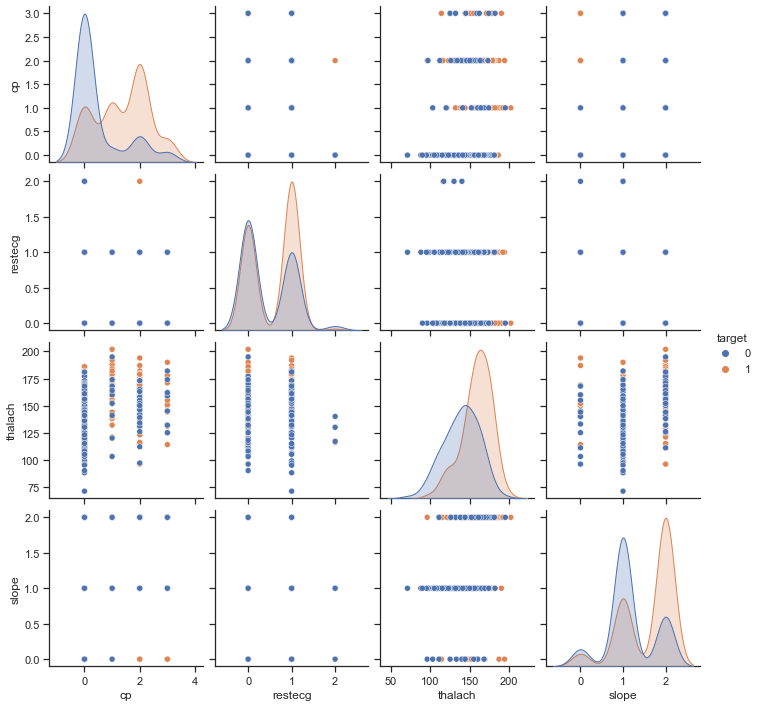

In [8]:
df_subset = df[["target","cp", "restecg", "thalach", "slope"]]

sns.set_theme(style="ticks")
sns.pairplot(df_subset, hue="target")

As we see in the pair plot, the four features have different distributions for each target class.

Let's check the distribution of each variable:

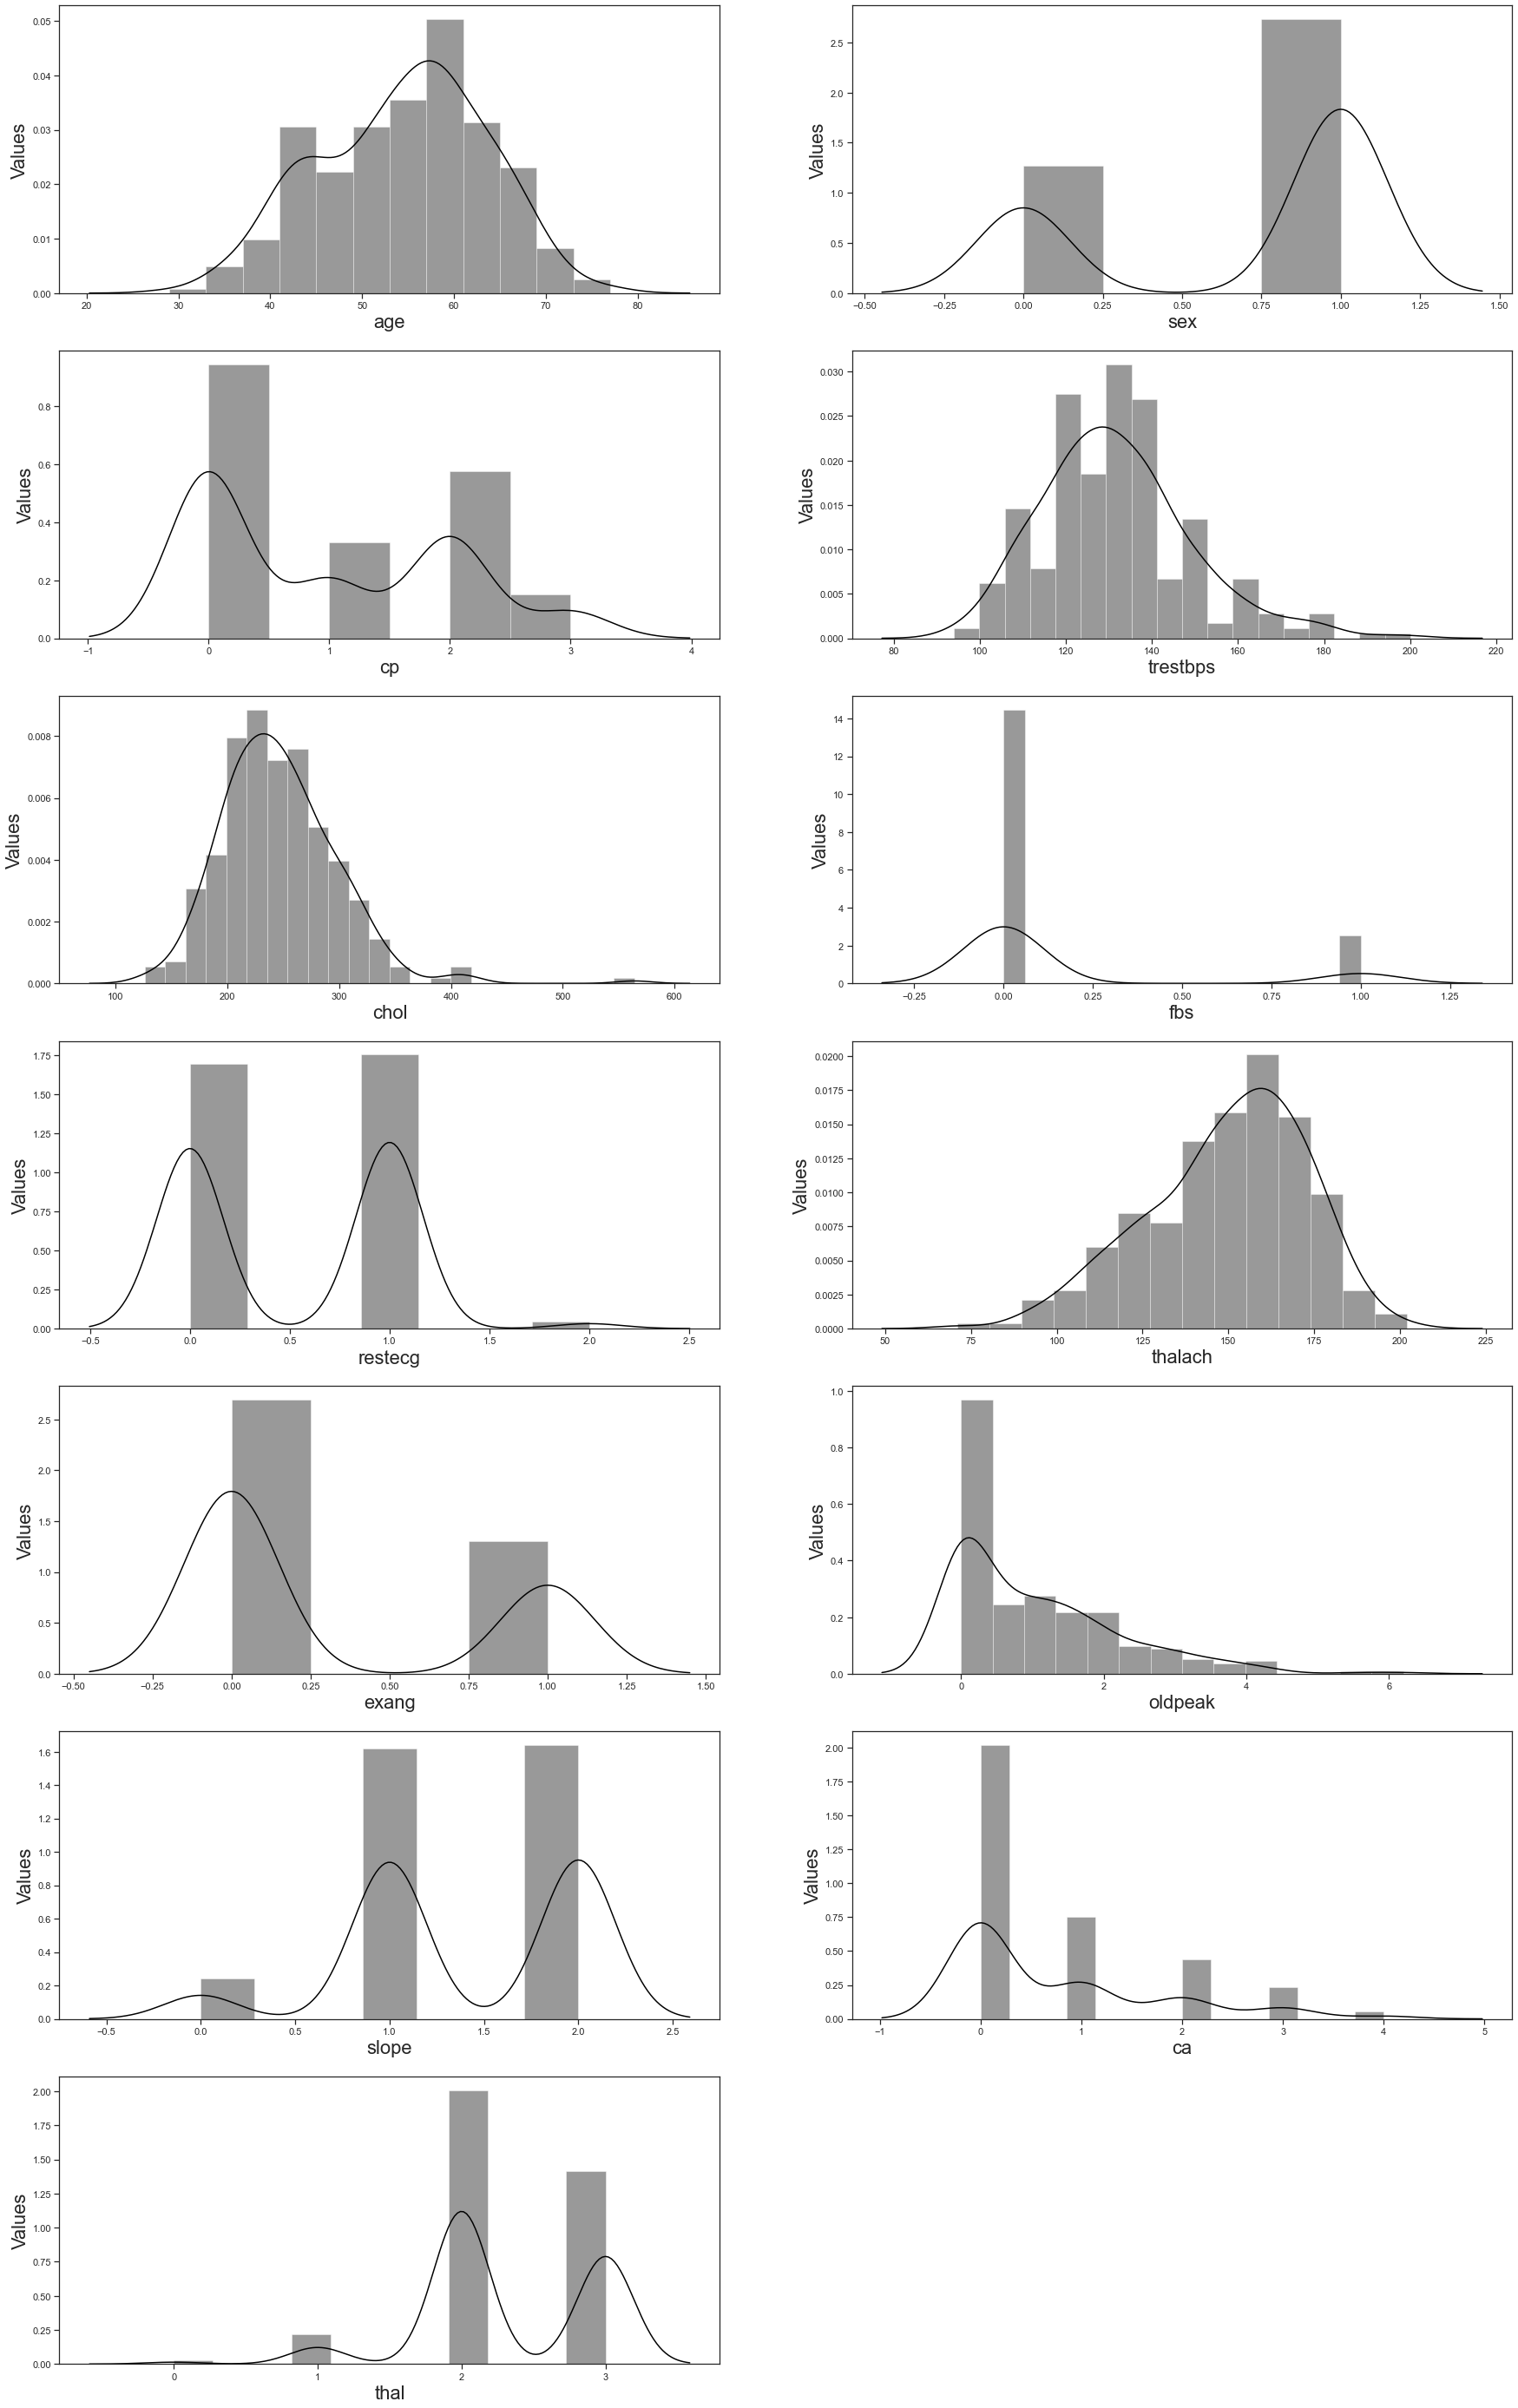

In [9]:
import warnings
warnings.filterwarnings('ignore')
 
plt.figure(figsize=(30,50))
plot_num=1

for column in df:
  if plot_num<14:
    ax=plt.subplot(7,2,plot_num)
    sns.distplot(df[column], color="black")
    plt.xlabel(column,fontsize=22)
    plt.ylabel('Values',fontsize=22)
  plot_num+=1
plt.show()

# Classification with KNN

Let's define our independent variables and our Response variable:

In [10]:
X=df.drop('target',axis=1).values    
y=df['target'].values

Since we use KNN and it calculates the distance between our data points. For the model to work better, we scale our data using the normal distribution:

In [11]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

Scaler = preprocessing.StandardScaler().fit(X)
X = Scaler.transform(X)
X[0:3]

array([[ 0.9521966 ,  0.68100522,  1.97312292,  0.76395577, -0.25633371,
         2.394438  , -1.00583187,  0.01544279, -0.69663055,  1.08733806,
        -2.27457861, -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, -0.09273778,  0.07219949,
        -0.41763453,  0.89896224,  1.63347147, -0.69663055,  2.12257273,
        -2.27457861, -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, -0.09273778, -0.81677269,
        -0.41763453, -1.00583187,  0.97751389, -0.69663055,  0.31091206,
         0.97635214, -0.71442887, -0.51292188]])

Splitting the dataset into train and test sets:

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 13) (242,)
Test set: (61, 13) (61,)


In [13]:
from sklearn.neighbors import KNeighborsClassifier

Fitting a KNN Model with K=4:

In [14]:
k = 4
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

KNeighborsClassifier(n_neighbors=4)

Prediction for the test set:

In [15]:
knn_yhat = knn.predict(X_test)
knn_yhat[0:5]

array([0, 0, 1, 1, 0])

Evaluation of the model:

In [16]:
from sklearn import metrics
KNN_Score = metrics.accuracy_score(y_test, knn_yhat)                                               
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ",KNN_Score )

Train set Accuracy:  0.859504132231405
Test set Accuracy:  0.8032786885245902


We considered the K equal to 4 but is that the best K? let's find out:

In [17]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.7704918 , 0.7704918 , 0.80327869, 0.80327869, 0.80327869,
       0.81967213, 0.83606557, 0.81967213, 0.81967213])

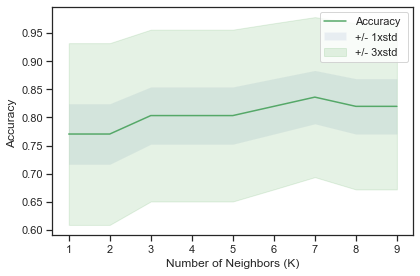

The best accuracy for KNN method was with 0.8360655737704918 with k= 7


In [18]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy for KNN method was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [19]:
k = 7
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

KNeighborsClassifier(n_neighbors=7)

In [20]:
knn_yhat = knn.predict(X_test)
knn_yhat[0:5]

array([0, 0, 1, 1, 0])

## KNN Evaluation

In [21]:
KNN_Score = metrics.accuracy_score(y_test, knn_yhat)                                               
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ",KNN_Score )

Train set Accuracy:  0.8512396694214877
Test set Accuracy:  0.8360655737704918


Defining  a function to plot confusion matrix (we will use it for all methods):

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score ,f1_score
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[30  6]
 [ 4 21]]


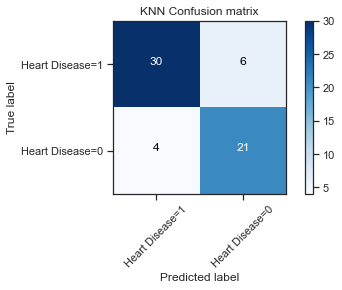

In [23]:
# Compute confusion matrix
KNN_cnf_matrix = confusion_matrix(y_test, knn_yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'],normalize= False,  title='KNN Confusion matrix')

In [24]:
print (classification_report(y_test, knn_yhat))
KNN_Recall = recall_score(y_test, knn_yhat)
KNN_F1Score = f1_score(y_test, knn_yhat)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        25
           1       0.88      0.83      0.86        36

    accuracy                           0.84        61
   macro avg       0.83      0.84      0.83        61
weighted avg       0.84      0.84      0.84        61



# Classification with Decision Tree

In [25]:
X=df.drop('target',axis=1).values    
y=df['target'].values

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 13) (242,)
Test set: (61, 13) (61,)


In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [29]:
DTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [30]:
Tree_yhat = DTree.predict(X_test)

## Decision Tree Evaluation

In [31]:
from sklearn import metrics

DTree_Score = metrics.accuracy_score(y_test, Tree_yhat) 
print("Train set Accuracy: ", metrics.accuracy_score(y_train, DTree.predict(X_train)))
print("DecisionTrees's Accuracy: ", DTree_Score)

Train set Accuracy:  0.8677685950413223
DecisionTrees's Accuracy:  0.8524590163934426


Confusion matrix, without normalization
[[33  3]
 [ 6 19]]


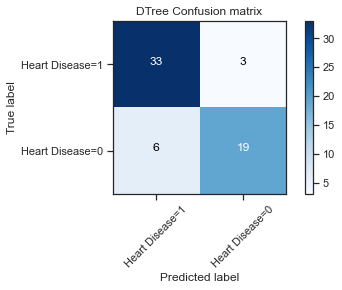

In [32]:
# Compute confusion matrix
DTree_cnf_matrix = confusion_matrix(y_test, Tree_yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DTree_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'],normalize= False,  title='DTree Confusion matrix')

In [33]:
print (classification_report(y_test, Tree_yhat))
DTree_Recall = recall_score(y_test, Tree_yhat)
DTree_F1Score = f1_score(y_test, Tree_yhat)

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.85      0.92      0.88        36

    accuracy                           0.85        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61



Now, We are going to plot the Tree:

In [34]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

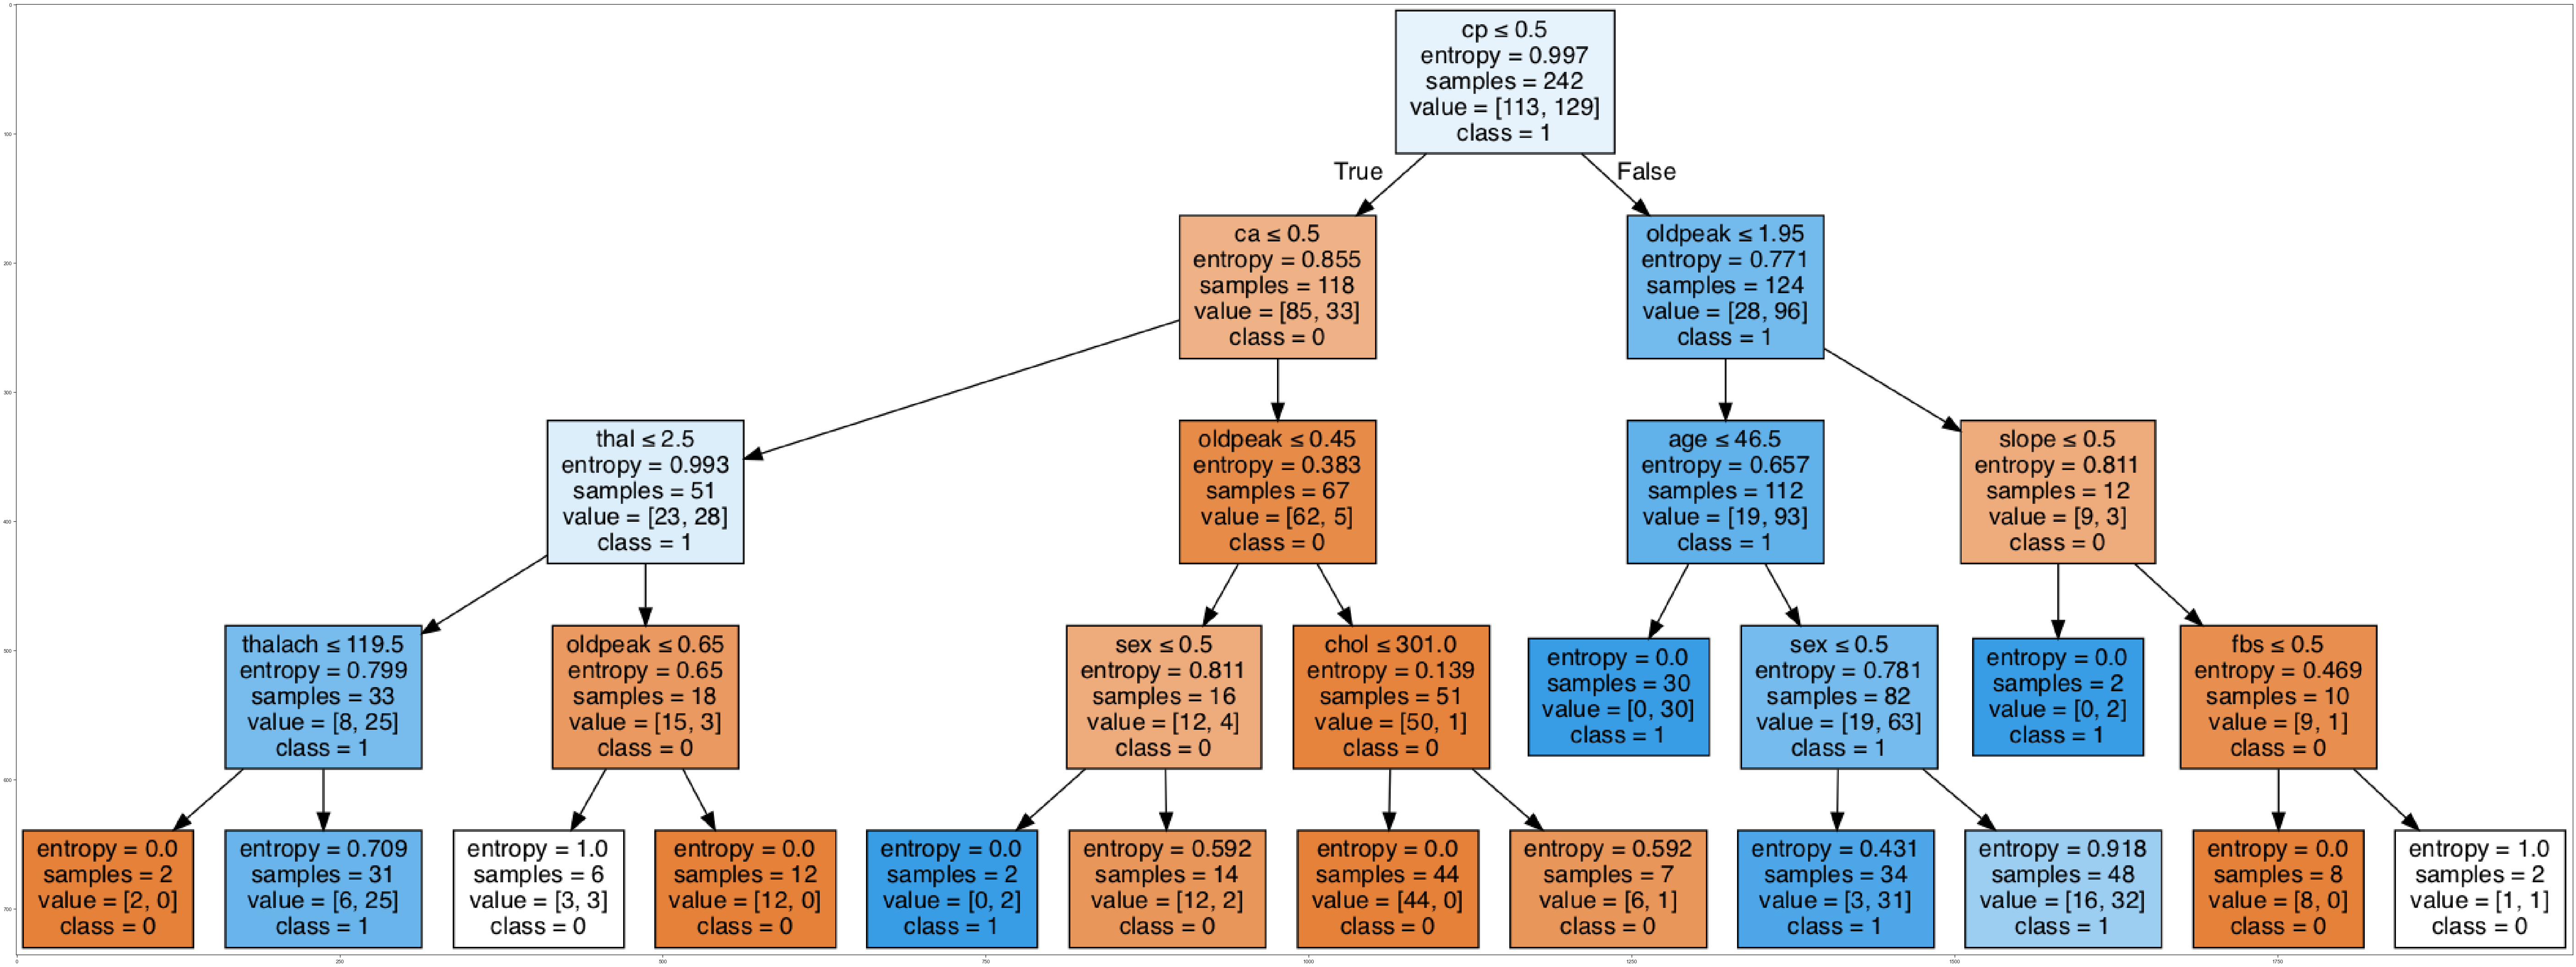

In [35]:
dot_data = StringIO()
filename = "Decision Tree_Heart Disease.png"
featureNames = df.columns[0:13]
out=tree.export_graphviz(DTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train).astype(str), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Classification with Logistic Regression

In [36]:
X=df.drop('target',axis=1).values    
y=df['target'].values

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 13) (242,)
Test set: (61, 13) (61,)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [39]:
LR_yhat = LR.predict(X_test)
LR_yhat[0:5]

array([1, 0, 1, 1, 1])

In [40]:
LR_yhat_prob = LR.predict_proba(X_test)
LR_yhat_prob[0:5]

array([[0.24, 0.76],
       [0.69, 0.31],
       [0.39, 0.61],
       [0.12, 0.88],
       [0.36, 0.64]])

## Logistic Regression Evaluation

In [41]:
from sklearn import metrics

LR_Score = metrics.accuracy_score(y_test, LR_yhat) 
print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Logistic Regression's Accuracy: ", LR_Score)

Train set Accuracy:  0.7644628099173554
Logistic Regression's Accuracy:  0.819672131147541


Confusion matrix, without normalization
[[34  2]
 [ 9 16]]


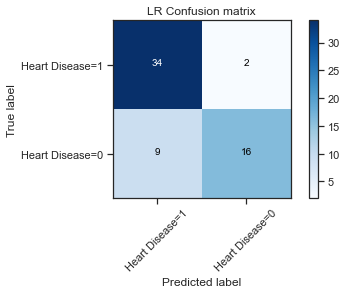

In [42]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, LR_yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'],normalize= False,  title='LR Confusion matrix')

In [43]:
print (classification_report(y_test, LR_yhat))
LR_Recall = recall_score(y_test, LR_yhat)
LR_F1Score = f1_score(y_test, LR_yhat)

              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.79      0.94      0.86        36

    accuracy                           0.82        61
   macro avg       0.84      0.79      0.80        61
weighted avg       0.83      0.82      0.81        61



# Classification with SVM

In [44]:
X=df.drop('target',axis=1).values    
y=df['target'].values

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 13) (242,)
Test set: (61, 13) (61,)


In [46]:
from sklearn import svm
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train) 

SVC()

In [47]:
SVM_yhat = SVM.predict(X_test)
SVM_yhat [0:5]

array([1, 1, 1, 1, 0])

In [48]:
from sklearn import metrics

SVM_Score = metrics.accuracy_score(y_test, SVM_yhat)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, SVM.predict(X_train)))
print("SVM's Accuracy: ", SVM_Score)

Train set Accuracy:  0.6735537190082644
SVM's Accuracy:  0.6721311475409836


Confusion matrix, without normalization
[[31  5]
 [15 10]]


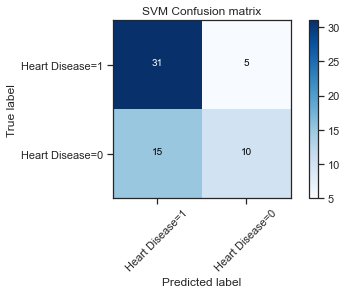

In [49]:
# Compute confusion matrix
SVM_cnf_matrix = confusion_matrix(y_test, SVM_yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'],normalize= False,  title='SVM Confusion matrix')

In [50]:
print (classification_report(y_test, SVM_yhat))
SVM_Recall = recall_score(y_test, SVM_yhat)
SVM_F1Score = f1_score(y_test, SVM_yhat)

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.67      0.86      0.76        36

    accuracy                           0.67        61
   macro avg       0.67      0.63      0.63        61
weighted avg       0.67      0.67      0.65        61



# Comparing Classification Methods

In [51]:
pd.options.display.float_format = "{:,.2f}".format

Scores_Comparison = {'Methoods': ['KNN', 'Decision Tree', 'Logistic Regression', 'SVM'],
                     'Accuracy': [KNN_Score, DTree_Score, LR_Score, SVM_Score] ,
                     'Recall': [KNN_Recall, DTree_Recall, LR_Recall, SVM_Recall],
                     'F1-Score': [KNN_F1Score, DTree_F1Score, LR_F1Score, SVM_F1Score]
                    }
Scores_Comparison = pd.DataFrame(data=Scores_Comparison)
Scores_Comparison.sort_values(by='Recall', ascending=False)

,Methoods,Accuracy,Recall,F1-Score
2,Logistic Regression,0.82,0.94,0.86
1,Decision Tree,0.85,0.92,0.88
3,SVM,0.67,0.86,0.76
0,KNN,0.84,0.83,0.86


# Conclusion

Although the Decision Tree method has higher accuracy and f1-score, in this case (detecting heart disease), it is essential that we can classify those with heart disease with better accuracy, so I choose logistic regression as the best model for the classification of this dataset since it has a higher recall score.